<a href="https://colab.research.google.com/github/DavidSalmon13/GenAI/blob/main/HW3/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gen-AI Home Work assigment 3
# Name: David Schwartzman
# Date: 10.10.2024
# Description: this model will build a VAE and test its perfomance

In [ ]:

#Install essential Python libraries for machine learning and data processing,
##and download the SVHN dataset for model training and testing.
!pip install tensorflow numpy scipy pillow matplotlib
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-10-09 03:31:47--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  3.29MB/s    in 53s     

2024-10-09 03:32:40 (3.26 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-09 03:32:40--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  1.77MB/s    in 25s     

2024-10-09 03:33:05 (2.46 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [ ]:
from scipy.io import loadmat  # Import the function 'loadmat' from the 'scipy.io' module to enable loading MATLAB files.
import numpy as np  # Import the 'numpy' library, often used for numerical operations, under the alias 'np'.
import os
from scipy.io import loadmat
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Attempt to load the alternate files
try:
    train_data = loadmat('train_32x32.mat.1')
    test_data = loadmat('test_32x32.mat.1')
except Exception as e:
    print(f"Error loading alternate files: {e}")

print(os.listdir('.'))
# Load data
train_data = loadmat('train_32x32.mat')  # Load the training data from the MATLAB file 'train_32x32.mat'.
test_data = loadmat('test_32x32.mat')  # Load the test data from the MATLAB file 'test_32x32.mat'.

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0  # Rearrange the axes of the training images for processing, convert to float32, and normalize the pixel values.
y_train = train_data['y'].flatten()  # Flatten the training labels array to a single dimension.
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0  # Rearrange the axes of the testing images for processing, convert to float32, and normalize the pixel values.
y_test = test_data['y'].flatten()  # Flatten the test labels array to a single dimension.

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')  # Print the shape of the processed training data.
print(f'Test data shape: {x_test.shape}')  # Print the shape of the processed test data.

Error loading alternate files: [Errno 2] No such file or directory: 'train_32x32.mat.1.mat'
['.config', 'train_32x32.mat', 'test_32x32.mat', 'sample_data']
Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


In [ ]:

# Building the VAE
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian."""
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(latent_dim):
    """Builds the encoder model."""
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
    encoder = models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

def build_decoder(latent_dim):
    """Builds the decoder model."""
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((8, 8, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    decoder = models.Model(latent_inputs, outputs, name='decoder')
    return decoder




In [ ]:
class VAE(tf.keras.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)


        reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(tf.square(inputs - reconstruction), axis=(1, 2, 3))
    )
        kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    )
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)


        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return z_mean, z_log_var, reconstruction

In [ ]:
##Step 3: Train the VAE with Various Latent Dimensions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

latent_dims = [2, 5, 10]
for dim in latent_dims:
    print(f"\nTraining VAE with latent dimension: {dim}")
    encoder = build_encoder(latent_dim=dim)
    decoder = build_decoder(latent_dim=dim)
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

    # Updated callbacks with mode='min'
    checkpoint_callback = ModelCheckpoint(
        filepath=f'vae_weights_dim_{dim}.weights.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_total_loss',
        mode='min',
        verbose=1
    )
    early_stopping_callback = EarlyStopping(
        monitor='val_total_loss',
        mode='min',
        patience=10,
        verbose=1
    )

    # Train the model with the updated callbacks
    vae.fit(
        x_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, None),
        callbacks=[checkpoint_callback, early_stopping_callback]
    )




Training VAE with latent dimension: 2
Epoch 1/50
572/573 [============================>.] - ETA: 0s - total_loss: 100.5076 - reconstruction_loss: 98.9797 - kl_loss: 1.5278
Epoch 1: val_total_loss improved from inf to 107.44080, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 29s 47ms/step - total_loss: 100.4712 - reconstruction_loss: 98.9420 - kl_loss: 1.5291 - val_total_loss: 107.4408 - val_reconstruction_loss: 104.4567 - val_kl_loss: 2.9841
Epoch 2/50
573/573 [==============================] - ETA: 0s - total_loss: 82.1462 - reconstruction_loss: 79.2218 - kl_loss: 2.9244
Epoch 2: val_total_loss improved from 107.44080 to 84.47561, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 26s 46ms/step - total_loss: 82.1462 - reconstruction_loss: 79.2218 - kl_loss: 2.9244 - val_total_loss: 84.4756 - val_reconstruction_loss: 80.9275 - val_kl_loss: 3.5481
Epoch 3/50
573/573 [==============================] - ETA: 0s - total_loss: 62.7243 - reconstruction_loss: 58.7415 - kl_loss: 3.9828
Epoch 3: val_total_loss improved from 84.47561 to 62.30157, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 26s 45ms/step - total_loss: 62.7243 - reconstruction_loss: 58.7415 - kl_loss: 3.9828 - val_total_loss: 62.3016 - val_reconstruction_loss: 57.7855 - val_kl_loss: 4.5160
Epoch 4/50
573/573 [==============================] - ETA: 0s - total_loss: 53.7285 - reconstruction_loss: 49.4439 - kl_loss: 4.2848
Epoch 4: val_total_loss improved from 62.30157 to 56.88739, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 26s 45ms/step - total_loss: 53.7285 - reconstruction_loss: 49.4439 - kl_loss: 4.2848 - val_total_loss: 56.8874 - val_reconstruction_loss: 52.5434 - val_kl_loss: 4.3440
Epoch 5/50
572/573 [============================>.] - ETA: 0s - total_loss: 51.7607 - reconstruction_loss: 47.5641 - kl_loss: 4.1966
Epoch 5: val_total_loss improved from 56.88739 to 55.45438, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 26s 46ms/step - total_loss: 51.7521 - reconstruction_loss: 47.5555 - kl_loss: 4.1966 - val_total_loss: 55.4544 - val_reconstruction_loss: 51.1887 - val_kl_loss: 4.2657
Epoch 6/50
572/573 [============================>.] - ETA: 0s - total_loss: 50.9400 - reconstruction_loss: 46.8118 - kl_loss: 4.1282
Epoch 6: val_total_loss improved from 55.45438 to 54.53707, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 26s 45ms/step - total_loss: 50.9259 - reconstruction_loss: 46.7981 - kl_loss: 4.1278 - val_total_loss: 54.5371 - val_reconstruction_loss: 50.2894 - val_kl_loss: 4.2477
Epoch 7/50
573/573 [==============================] - ETA: 0s - total_loss: 50.4615 - reconstruction_loss: 46.3852 - kl_loss: 4.0764
Epoch 7: val_total_loss improved from 54.53707 to 53.88416, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 27s 46ms/step - total_loss: 50.4615 - reconstruction_loss: 46.3852 - kl_loss: 4.0764 - val_total_loss: 53.8842 - val_reconstruction_loss: 49.6956 - val_kl_loss: 4.1886
Epoch 8/50
573/573 [==============================] - ETA: 0s - total_loss: 50.1233 - reconstruction_loss: 46.1020 - kl_loss: 4.0214
Epoch 8: val_total_loss improved from 53.88416 to 53.63531, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 25s 44ms/step - total_loss: 50.1233 - reconstruction_loss: 46.1020 - kl_loss: 4.0214 - val_total_loss: 53.6353 - val_reconstruction_loss: 49.5241 - val_kl_loss: 4.1112
Epoch 9/50
572/573 [============================>.] - ETA: 0s - total_loss: 49.8415 - reconstruction_loss: 45.8671 - kl_loss: 3.9744
Epoch 9: val_total_loss improved from 53.63531 to 53.21967, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 25s 44ms/step - total_loss: 49.8394 - reconstruction_loss: 45.8651 - kl_loss: 3.9743 - val_total_loss: 53.2197 - val_reconstruction_loss: 49.1258 - val_kl_loss: 4.0939
Epoch 10/50
572/573 [============================>.] - ETA: 0s - total_loss: 49.6475 - reconstruction_loss: 45.7007 - kl_loss: 3.9467
Epoch 10: val_total_loss improved from 53.21967 to 52.82304, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 25s 44ms/step - total_loss: 49.6411 - reconstruction_loss: 45.6947 - kl_loss: 3.9464 - val_total_loss: 52.8230 - val_reconstruction_loss: 48.7301 - val_kl_loss: 4.0929
Epoch 11/50
573/573 [==============================] - ETA: 0s - total_loss: 49.4932 - reconstruction_loss: 45.5735 - kl_loss: 3.9197
Epoch 11: val_total_loss did not improve from 52.82304
573/573 [==============================] - 25s 44ms/step - total_loss: 49.4932 - reconstruction_loss: 45.5735 - kl_loss: 3.9197 - val_total_loss: 52.9817 - val_reconstruction_loss: 48.8516 - val_kl_loss: 4.1300
Epoch 12/50
573/573 [==============================] - ETA: 0s - total_loss: 49.3370 - reconstruction_loss: 45.4304 - kl_loss: 3.9066
Epoch 12: val_total_loss improved from 52.82304 to 52.61933, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 25s 43ms/step - total_loss: 49.3370 - reconstruction_loss: 45.4304 - kl_loss: 3.9066 - val_total_loss: 52.6193 - val_reconstruction_loss: 48.4301 - val_kl_loss: 4.1892
Epoch 13/50
573/573 [==============================] - ETA: 0s - total_loss: 49.2118 - reconstruction_loss: 45.3115 - kl_loss: 3.9003
Epoch 13: val_total_loss did not improve from 52.61933
573/573 [==============================] - 25s 44ms/step - total_loss: 49.2118 - reconstruction_loss: 45.3115 - kl_loss: 3.9003 - val_total_loss: 52.6541 - val_reconstruction_loss: 48.5368 - val_kl_loss: 4.1174
Epoch 14/50
572/573 [============================>.] - ETA: 0s - total_loss: 49.1172 - reconstruction_loss: 45.2192 - kl_loss: 3.8979
Epoch 14: val_total_loss improved from 52.61933 to 52.24982, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 25s 44ms/step - total_loss: 49.1256 - reconstruction_loss: 45.2277 - kl_loss: 3.8979 - val_total_loss: 52.2498 - val_reconstruction_loss: 48.0753 - val_kl_loss: 4.1745
Epoch 15/50
572/573 [============================>.] - ETA: 0s - total_loss: 49.0413 - reconstruction_loss: 45.1356 - kl_loss: 3.9057
Epoch 15: val_total_loss improved from 52.24982 to 52.21428, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 25s 44ms/step - total_loss: 49.0575 - reconstruction_loss: 45.1509 - kl_loss: 3.9066 - val_total_loss: 52.2143 - val_reconstruction_loss: 47.9815 - val_kl_loss: 4.2328
Epoch 16/50
573/573 [==============================] - ETA: 0s - total_loss: 48.9706 - reconstruction_loss: 45.0694 - kl_loss: 3.9011
Epoch 16: val_total_loss improved from 52.21428 to 52.01516, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 48.9706 - reconstruction_loss: 45.0694 - kl_loss: 3.9011 - val_total_loss: 52.0152 - val_reconstruction_loss: 47.7848 - val_kl_loss: 4.2304
Epoch 17/50
572/573 [============================>.] - ETA: 0s - total_loss: 48.8878 - reconstruction_loss: 44.9782 - kl_loss: 3.9097
Epoch 17: val_total_loss improved from 52.01516 to 51.85573, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 48.8758 - reconstruction_loss: 44.9663 - kl_loss: 3.9095 - val_total_loss: 51.8557 - val_reconstruction_loss: 47.6753 - val_kl_loss: 4.1804
Epoch 18/50
572/573 [============================>.] - ETA: 0s - total_loss: 48.8172 - reconstruction_loss: 44.8992 - kl_loss: 3.9180
Epoch 18: val_total_loss improved from 51.85573 to 51.68276, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 48.8113 - reconstruction_loss: 44.8935 - kl_loss: 3.9178 - val_total_loss: 51.6828 - val_reconstruction_loss: 47.4675 - val_kl_loss: 4.2153
Epoch 19/50
572/573 [============================>.] - ETA: 0s - total_loss: 48.7646 - reconstruction_loss: 44.8315 - kl_loss: 3.9330
Epoch 19: val_total_loss improved from 51.68276 to 51.62633, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 48.7586 - reconstruction_loss: 44.8254 - kl_loss: 3.9332 - val_total_loss: 51.6263 - val_reconstruction_loss: 47.3414 - val_kl_loss: 4.2849
Epoch 20/50
572/573 [============================>.] - ETA: 0s - total_loss: 48.6789 - reconstruction_loss: 44.7422 - kl_loss: 3.9366
Epoch 20: val_total_loss improved from 51.62633 to 51.43217, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 25s 43ms/step - total_loss: 48.6818 - reconstruction_loss: 44.7451 - kl_loss: 3.9367 - val_total_loss: 51.4322 - val_reconstruction_loss: 47.0547 - val_kl_loss: 4.3775
Epoch 21/50
573/573 [==============================] - ETA: 0s - total_loss: 48.6336 - reconstruction_loss: 44.6836 - kl_loss: 3.9501
Epoch 21: val_total_loss did not improve from 51.43217
573/573 [==============================] - 24s 42ms/step - total_loss: 48.6336 - reconstruction_loss: 44.6836 - kl_loss: 3.9501 - val_total_loss: 51.5837 - val_reconstruction_loss: 47.3841 - val_kl_loss: 4.1996
Epoch 22/50
573/573 [==============================] - ETA: 0s - total_loss: 48.5744 - reconstruction_loss: 44.6204 - kl_loss: 3.9540
Epoch 22: val_total_loss improved from 51.43217 to 51.27208, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 48.5744 - reconstruction_loss: 44.6204 - kl_loss: 3.9540 - val_total_loss: 51.2721 - val_reconstruction_loss: 46.9724 - val_kl_loss: 4.2997
Epoch 23/50
572/573 [============================>.] - ETA: 0s - total_loss: 48.5153 - reconstruction_loss: 44.5526 - kl_loss: 3.9627
Epoch 23: val_total_loss improved from 51.27208 to 51.17084, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 48.5138 - reconstruction_loss: 44.5513 - kl_loss: 3.9625 - val_total_loss: 51.1708 - val_reconstruction_loss: 46.8973 - val_kl_loss: 4.2736
Epoch 24/50
573/573 [==============================] - ETA: 0s - total_loss: 48.4675 - reconstruction_loss: 44.4993 - kl_loss: 3.9683
Epoch 24: val_total_loss did not improve from 51.17084
573/573 [==============================] - 24s 41ms/step - total_loss: 48.4675 - reconstruction_loss: 44.4993 - kl_loss: 3.9683 - val_total_loss: 51.3088 - val_reconstruction_loss: 47.0027 - val_kl_loss: 4.3061
Epoch 25/50
572/573 [============================>.] - ETA: 0s - total_loss: 48.4058 - reconstruction_loss: 44.4325 - kl_loss: 3.9734
Epoch 25: val_total_loss improved from 51.17084 to 51.00110, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 24s 43ms/step - total_loss: 48.4206 - reconstruction_loss: 44.4465 - kl_loss: 3.9742 - val_total_loss: 51.0011 - val_reconstruction_loss: 46.6866 - val_kl_loss: 4.3145
Epoch 26/50
573/573 [==============================] - ETA: 0s - total_loss: 48.3640 - reconstruction_loss: 44.3750 - kl_loss: 3.9889
Epoch 26: val_total_loss improved from 51.00110 to 50.93459, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 25s 43ms/step - total_loss: 48.3640 - reconstruction_loss: 44.3750 - kl_loss: 3.9889 - val_total_loss: 50.9346 - val_reconstruction_loss: 46.5701 - val_kl_loss: 4.3645
Epoch 27/50
573/573 [==============================] - ETA: 0s - total_loss: 48.3201 - reconstruction_loss: 44.3306 - kl_loss: 3.9895
Epoch 27: val_total_loss did not improve from 50.93459
573/573 [==============================] - 25s 44ms/step - total_loss: 48.3201 - reconstruction_loss: 44.3306 - kl_loss: 3.9895 - val_total_loss: 50.9834 - val_reconstruction_loss: 46.6965 - val_kl_loss: 4.2869
Epoch 28/50
573/573 [==============================] - ETA: 0s - total_loss: 48.3047 - reconstruction_loss: 44.3044 - kl_loss: 4.0003
Epoch 28: val_total_loss did not improve from 50.93459
573/573 [==============================] - 25s 44ms/step - total_loss: 48.3047 - reconstruction_loss: 44.3044 - kl_loss: 4.0003 - val_total_loss: 50.9659 - val_reconstruction_loss: 46.6165 - val_kl_lo

573/573 [==============================] - 25s 44ms/step - total_loss: 48.2400 - reconstruction_loss: 44.2344 - kl_loss: 4.0056 - val_total_loss: 50.8566 - val_reconstruction_loss: 46.5046 - val_kl_loss: 4.3520
Epoch 30/50
572/573 [============================>.] - ETA: 0s - total_loss: 48.1995 - reconstruction_loss: 44.1844 - kl_loss: 4.0151
Epoch 30: val_total_loss improved from 50.85659 to 50.74278, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 25s 43ms/step - total_loss: 48.1921 - reconstruction_loss: 44.1767 - kl_loss: 4.0154 - val_total_loss: 50.7428 - val_reconstruction_loss: 46.3524 - val_kl_loss: 4.3904
Epoch 31/50
573/573 [==============================] - ETA: 0s - total_loss: 48.1485 - reconstruction_loss: 44.1323 - kl_loss: 4.0162
Epoch 31: val_total_loss did not improve from 50.74278
573/573 [==============================] - 24s 42ms/step - total_loss: 48.1485 - reconstruction_loss: 44.1323 - kl_loss: 4.0162 - val_total_loss: 50.8050 - val_reconstruction_loss: 46.4664 - val_kl_loss: 4.3386
Epoch 32/50
573/573 [==============================] - ETA: 0s - total_loss: 48.1208 - reconstruction_loss: 44.0927 - kl_loss: 4.0281
Epoch 32: val_total_loss did not improve from 50.74278
573/573 [==============================] - 24s 42ms/step - total_loss: 48.1208 - reconstruction_loss: 44.0927 - kl_loss: 4.0281 - val_total_loss: 50.8571 - val_reconstruction_loss: 46.4518 - val_kl_lo

573/573 [==============================] - 25s 44ms/step - total_loss: 48.0758 - reconstruction_loss: 44.0387 - kl_loss: 4.0371 - val_total_loss: 50.6979 - val_reconstruction_loss: 46.2846 - val_kl_loss: 4.4133
Epoch 34/50
573/573 [==============================] - ETA: 0s - total_loss: 48.0207 - reconstruction_loss: 43.9803 - kl_loss: 4.0403
Epoch 34: val_total_loss did not improve from 50.69791
573/573 [==============================] - 24s 42ms/step - total_loss: 48.0207 - reconstruction_loss: 43.9803 - kl_loss: 4.0403 - val_total_loss: 50.7047 - val_reconstruction_loss: 46.3064 - val_kl_loss: 4.3983
Epoch 35/50
573/573 [==============================] - ETA: 0s - total_loss: 47.9901 - reconstruction_loss: 43.9378 - kl_loss: 4.0524
Epoch 35: val_total_loss did not improve from 50.69791
573/573 [==============================] - 24s 42ms/step - total_loss: 47.9901 - reconstruction_loss: 43.9378 - kl_loss: 4.0524 - val_total_loss: 50.8061 - val_reconstruction_loss: 46.4126 - val_kl_lo

573/573 [==============================] - 25s 43ms/step - total_loss: 47.8674 - reconstruction_loss: 43.7985 - kl_loss: 4.0690 - val_total_loss: 50.5690 - val_reconstruction_loss: 46.1840 - val_kl_loss: 4.3850
Epoch 38/50
573/573 [==============================] - ETA: 0s - total_loss: 47.8271 - reconstruction_loss: 43.7559 - kl_loss: 4.0713
Epoch 38: val_total_loss improved from 50.56895 to 50.52480, saving model to vae_weights_dim_2.weights.h5


573/573 [==============================] - 24s 43ms/step - total_loss: 47.8271 - reconstruction_loss: 43.7559 - kl_loss: 4.0713 - val_total_loss: 50.5248 - val_reconstruction_loss: 46.0545 - val_kl_loss: 4.4703
Epoch 39/50
573/573 [==============================] - ETA: 0s - total_loss: 47.7824 - reconstruction_loss: 43.6922 - kl_loss: 4.0903
Epoch 39: val_total_loss did not improve from 50.52480
573/573 [==============================] - 25s 43ms/step - total_loss: 47.7824 - reconstruction_loss: 43.6922 - kl_loss: 4.0903 - val_total_loss: 50.6548 - val_reconstruction_loss: 46.1758 - val_kl_loss: 4.4790
Epoch 40/50
572/573 [============================>.] - ETA: 0s - total_loss: 47.7253 - reconstruction_loss: 43.6320 - kl_loss: 4.0933
Epoch 40: val_total_loss did not improve from 50.52480
573/573 [==============================] - 24s 43ms/step - total_loss: 47.7333 - reconstruction_loss: 43.6396 - kl_loss: 4.0936 - val_total_loss: 50.7829 - val_reconstruction_loss: 46.3284 - val_kl_lo

573/573 [==============================] - 25s 43ms/step - total_loss: 47.4356 - reconstruction_loss: 43.2768 - kl_loss: 4.1589 - val_total_loss: 50.5037 - val_reconstruction_loss: 46.0580 - val_kl_loss: 4.4457
Epoch 48/50
572/573 [============================>.] - ETA: 0s - total_loss: 47.3928 - reconstruction_loss: 43.2296 - kl_loss: 4.1632
Epoch 48: val_total_loss did not improve from 50.50365
573/573 [==============================] - 24s 43ms/step - total_loss: 47.3948 - reconstruction_loss: 43.2313 - kl_loss: 4.1634 - val_total_loss: 50.8510 - val_reconstruction_loss: 46.4071 - val_kl_loss: 4.4439
Epoch 49/50
573/573 [==============================] - ETA: 0s - total_loss: 47.3715 - reconstruction_loss: 43.1968 - kl_loss: 4.1747
Epoch 49: val_total_loss did not improve from 50.50365
573/573 [==============================] - 25s 43ms/step - total_loss: 47.3715 - reconstruction_loss: 43.1968 - kl_loss: 4.1747 - val_total_loss: 50.5637 - val_reconstruction_loss: 46.1175 - val_kl_lo

573/573 [==============================] - 26s 42ms/step - total_loss: 94.7990 - reconstruction_loss: 92.1340 - kl_loss: 2.6650 - val_total_loss: 95.5319 - val_reconstruction_loss: 92.3300 - val_kl_loss: 3.2018
Epoch 2/50
573/573 [==============================] - ETA: 0s - total_loss: 75.6800 - reconstruction_loss: 72.2428 - kl_loss: 3.4372
Epoch 2: val_total_loss improved from 95.53188 to 83.87758, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 40ms/step - total_loss: 75.6800 - reconstruction_loss: 72.2428 - kl_loss: 3.4372 - val_total_loss: 83.8776 - val_reconstruction_loss: 79.6414 - val_kl_loss: 4.2362
Epoch 3/50
573/573 [==============================] - ETA: 0s - total_loss: 68.1553 - reconstruction_loss: 63.4494 - kl_loss: 4.7059
Epoch 3: val_total_loss improved from 83.87758 to 78.15530, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 41ms/step - total_loss: 68.1553 - reconstruction_loss: 63.4494 - kl_loss: 4.7059 - val_total_loss: 78.1553 - val_reconstruction_loss: 73.0635 - val_kl_loss: 5.0918
Epoch 4/50
573/573 [==============================] - ETA: 0s - total_loss: 63.6687 - reconstruction_loss: 58.6456 - kl_loss: 5.0231
Epoch 4: val_total_loss improved from 78.15530 to 69.34300, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 40ms/step - total_loss: 63.6687 - reconstruction_loss: 58.6456 - kl_loss: 5.0231 - val_total_loss: 69.3430 - val_reconstruction_loss: 64.2425 - val_kl_loss: 5.1005
Epoch 5/50
572/573 [============================>.] - ETA: 0s - total_loss: 49.0731 - reconstruction_loss: 43.2884 - kl_loss: 5.7847
Epoch 5: val_total_loss improved from 69.34300 to 48.48662, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 40ms/step - total_loss: 49.0587 - reconstruction_loss: 43.2739 - kl_loss: 5.7848 - val_total_loss: 48.4866 - val_reconstruction_loss: 42.3653 - val_kl_loss: 6.1213
Epoch 6/50
573/573 [==============================] - ETA: 0s - total_loss: 43.7974 - reconstruction_loss: 37.6278 - kl_loss: 6.1696
Epoch 6: val_total_loss improved from 48.48662 to 46.81429, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 43.7974 - reconstruction_loss: 37.6278 - kl_loss: 6.1696 - val_total_loss: 46.8143 - val_reconstruction_loss: 40.6196 - val_kl_loss: 6.1947
Epoch 7/50
573/573 [==============================] - ETA: 0s - total_loss: 42.6739 - reconstruction_loss: 36.3005 - kl_loss: 6.3734
Epoch 7: val_total_loss improved from 46.81429 to 45.76048, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 22s 39ms/step - total_loss: 42.6739 - reconstruction_loss: 36.3005 - kl_loss: 6.3734 - val_total_loss: 45.7605 - val_reconstruction_loss: 38.9932 - val_kl_loss: 6.7673
Epoch 8/50
572/573 [============================>.] - ETA: 0s - total_loss: 41.7665 - reconstruction_loss: 35.0203 - kl_loss: 6.7462
Epoch 8: val_total_loss improved from 45.76048 to 44.79385, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 41.7639 - reconstruction_loss: 35.0178 - kl_loss: 6.7461 - val_total_loss: 44.7939 - val_reconstruction_loss: 37.9416 - val_kl_loss: 6.8522
Epoch 9/50
573/573 [==============================] - ETA: 0s - total_loss: 41.4330 - reconstruction_loss: 34.6648 - kl_loss: 6.7681
Epoch 9: val_total_loss improved from 44.79385 to 44.77780, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 40ms/step - total_loss: 41.4330 - reconstruction_loss: 34.6648 - kl_loss: 6.7681 - val_total_loss: 44.7778 - val_reconstruction_loss: 37.9049 - val_kl_loss: 6.8729
Epoch 10/50
572/573 [============================>.] - ETA: 0s - total_loss: 41.2065 - reconstruction_loss: 34.4212 - kl_loss: 6.7854
Epoch 10: val_total_loss improved from 44.77780 to 44.57292, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 40ms/step - total_loss: 41.2111 - reconstruction_loss: 34.4249 - kl_loss: 6.7863 - val_total_loss: 44.5729 - val_reconstruction_loss: 37.5987 - val_kl_loss: 6.9742
Epoch 11/50
573/573 [==============================] - ETA: 0s - total_loss: 41.0633 - reconstruction_loss: 34.2560 - kl_loss: 6.8074
Epoch 11: val_total_loss did not improve from 44.57292
573/573 [==============================] - 23s 41ms/step - total_loss: 41.0633 - reconstruction_loss: 34.2560 - kl_loss: 6.8074 - val_total_loss: 44.8036 - val_reconstruction_loss: 37.7880 - val_kl_loss: 7.0155
Epoch 12/50
572/573 [============================>.] - ETA: 0s - total_loss: 40.9069 - reconstruction_loss: 34.0944 - kl_loss: 6.8125
Epoch 12: val_total_loss improved from 44.57292 to 44.47913, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 40ms/step - total_loss: 40.9065 - reconstruction_loss: 34.0943 - kl_loss: 6.8122 - val_total_loss: 44.4791 - val_reconstruction_loss: 37.4667 - val_kl_loss: 7.0124
Epoch 13/50
572/573 [============================>.] - ETA: 0s - total_loss: 40.7793 - reconstruction_loss: 33.9463 - kl_loss: 6.8330
Epoch 13: val_total_loss improved from 44.47913 to 44.09056, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 40.7796 - reconstruction_loss: 33.9467 - kl_loss: 6.8329 - val_total_loss: 44.0906 - val_reconstruction_loss: 37.2627 - val_kl_loss: 6.8278
Epoch 14/50
573/573 [==============================] - ETA: 0s - total_loss: 40.6524 - reconstruction_loss: 33.7984 - kl_loss: 6.8540
Epoch 14: val_total_loss improved from 44.09056 to 44.01347, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 40ms/step - total_loss: 40.6524 - reconstruction_loss: 33.7984 - kl_loss: 6.8540 - val_total_loss: 44.0135 - val_reconstruction_loss: 37.0987 - val_kl_loss: 6.9148
Epoch 15/50
572/573 [============================>.] - ETA: 0s - total_loss: 40.5530 - reconstruction_loss: 33.6791 - kl_loss: 6.8739
Epoch 15: val_total_loss improved from 44.01347 to 43.88490, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 41ms/step - total_loss: 40.5459 - reconstruction_loss: 33.6724 - kl_loss: 6.8735 - val_total_loss: 43.8849 - val_reconstruction_loss: 36.8715 - val_kl_loss: 7.0134
Epoch 16/50
573/573 [==============================] - ETA: 0s - total_loss: 40.4315 - reconstruction_loss: 33.5216 - kl_loss: 6.9099
Epoch 16: val_total_loss improved from 43.88490 to 43.78534, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 41ms/step - total_loss: 40.4315 - reconstruction_loss: 33.5216 - kl_loss: 6.9099 - val_total_loss: 43.7853 - val_reconstruction_loss: 36.8112 - val_kl_loss: 6.9741
Epoch 17/50
573/573 [==============================] - ETA: 0s - total_loss: 40.3613 - reconstruction_loss: 33.4316 - kl_loss: 6.9297
Epoch 17: val_total_loss improved from 43.78534 to 43.61404, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 41ms/step - total_loss: 40.3613 - reconstruction_loss: 33.4316 - kl_loss: 6.9297 - val_total_loss: 43.6140 - val_reconstruction_loss: 36.5560 - val_kl_loss: 7.0581
Epoch 18/50
572/573 [============================>.] - ETA: 0s - total_loss: 40.2650 - reconstruction_loss: 33.3275 - kl_loss: 6.9375
Epoch 18: val_total_loss improved from 43.61404 to 43.54760, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 41ms/step - total_loss: 40.2690 - reconstruction_loss: 33.3299 - kl_loss: 6.9391 - val_total_loss: 43.5476 - val_reconstruction_loss: 36.3706 - val_kl_loss: 7.1769
Epoch 19/50
572/573 [============================>.] - ETA: 0s - total_loss: 40.1823 - reconstruction_loss: 33.2362 - kl_loss: 6.9461
Epoch 19: val_total_loss improved from 43.54760 to 43.41419, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 41ms/step - total_loss: 40.1792 - reconstruction_loss: 33.2330 - kl_loss: 6.9462 - val_total_loss: 43.4142 - val_reconstruction_loss: 36.3992 - val_kl_loss: 7.0150
Epoch 20/50
572/573 [============================>.] - ETA: 0s - total_loss: 40.1399 - reconstruction_loss: 33.1757 - kl_loss: 6.9641
Epoch 20: val_total_loss did not improve from 43.41419
573/573 [==============================] - 23s 40ms/step - total_loss: 40.1371 - reconstruction_loss: 33.1718 - kl_loss: 6.9653 - val_total_loss: 43.4180 - val_reconstruction_loss: 36.2722 - val_kl_loss: 7.1458
Epoch 21/50
572/573 [============================>.] - ETA: 0s - total_loss: 40.0821 - reconstruction_loss: 33.1158 - kl_loss: 6.9662
Epoch 21: val_total_loss improved from 43.41419 to 43.32572, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 41ms/step - total_loss: 40.0890 - reconstruction_loss: 33.1224 - kl_loss: 6.9665 - val_total_loss: 43.3257 - val_reconstruction_loss: 36.1519 - val_kl_loss: 7.1738
Epoch 22/50
573/573 [==============================] - ETA: 0s - total_loss: 40.0310 - reconstruction_loss: 33.0417 - kl_loss: 6.9893
Epoch 22: val_total_loss improved from 43.32572 to 43.11340, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 41ms/step - total_loss: 40.0310 - reconstruction_loss: 33.0417 - kl_loss: 6.9893 - val_total_loss: 43.1134 - val_reconstruction_loss: 35.8374 - val_kl_loss: 7.2760
Epoch 23/50
573/573 [==============================] - ETA: 0s - total_loss: 39.9808 - reconstruction_loss: 32.9858 - kl_loss: 6.9950
Epoch 23: val_total_loss did not improve from 43.11340
573/573 [==============================] - 22s 39ms/step - total_loss: 39.9808 - reconstruction_loss: 32.9858 - kl_loss: 6.9950 - val_total_loss: 43.5905 - val_reconstruction_loss: 36.4015 - val_kl_loss: 7.1889
Epoch 24/50
573/573 [==============================] - ETA: 0s - total_loss: 39.9183 - reconstruction_loss: 32.9169 - kl_loss: 7.0014
Epoch 24: val_total_loss improved from 43.11340 to 43.05399, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 39.9183 - reconstruction_loss: 32.9169 - kl_loss: 7.0014 - val_total_loss: 43.0540 - val_reconstruction_loss: 35.8838 - val_kl_loss: 7.1702
Epoch 25/50
573/573 [==============================] - ETA: 0s - total_loss: 39.8801 - reconstruction_loss: 32.8669 - kl_loss: 7.0132
Epoch 25: val_total_loss improved from 43.05399 to 42.95791, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 39.8801 - reconstruction_loss: 32.8669 - kl_loss: 7.0132 - val_total_loss: 42.9579 - val_reconstruction_loss: 35.7584 - val_kl_loss: 7.1995
Epoch 26/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.8380 - reconstruction_loss: 32.8041 - kl_loss: 7.0339
Epoch 26: val_total_loss did not improve from 42.95791
573/573 [==============================] - 24s 41ms/step - total_loss: 39.8413 - reconstruction_loss: 32.8070 - kl_loss: 7.0343 - val_total_loss: 42.9614 - val_reconstruction_loss: 35.6731 - val_kl_loss: 7.2883
Epoch 27/50
573/573 [==============================] - ETA: 0s - total_loss: 39.7839 - reconstruction_loss: 32.7604 - kl_loss: 7.0235
Epoch 27: val_total_loss improved from 42.95791 to 42.95145, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 39.7839 - reconstruction_loss: 32.7604 - kl_loss: 7.0235 - val_total_loss: 42.9515 - val_reconstruction_loss: 35.6216 - val_kl_loss: 7.3298
Epoch 28/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.7565 - reconstruction_loss: 32.7139 - kl_loss: 7.0426
Epoch 28: val_total_loss improved from 42.95145 to 42.79479, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 39.7566 - reconstruction_loss: 32.7136 - kl_loss: 7.0430 - val_total_loss: 42.7948 - val_reconstruction_loss: 35.3971 - val_kl_loss: 7.3976
Epoch 29/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.7179 - reconstruction_loss: 32.6636 - kl_loss: 7.0543
Epoch 29: val_total_loss improved from 42.79479 to 42.68338, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 39.7242 - reconstruction_loss: 32.6690 - kl_loss: 7.0552 - val_total_loss: 42.6834 - val_reconstruction_loss: 35.3637 - val_kl_loss: 7.3197
Epoch 30/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.6798 - reconstruction_loss: 32.6120 - kl_loss: 7.0678
Epoch 30: val_total_loss did not improve from 42.68338
573/573 [==============================] - 24s 42ms/step - total_loss: 39.6848 - reconstruction_loss: 32.6167 - kl_loss: 7.0682 - val_total_loss: 42.7023 - val_reconstruction_loss: 35.4737 - val_kl_loss: 7.2285
Epoch 31/50
573/573 [==============================] - ETA: 0s - total_loss: 39.6375 - reconstruction_loss: 32.5746 - kl_loss: 7.0629
Epoch 31: val_total_loss did not improve from 42.68338
573/573 [==============================] - 23s 40ms/step - total_loss: 39.6375 - reconstruction_loss: 32.5746 - kl_loss: 7.0629 - val_total_loss: 43.2471 - val_reconstruction_loss: 35.9909 - val_kl_lo

573/573 [==============================] - 24s 42ms/step - total_loss: 39.6233 - reconstruction_loss: 32.5465 - kl_loss: 7.0769 - val_total_loss: 42.6464 - val_reconstruction_loss: 35.3097 - val_kl_loss: 7.3366
Epoch 33/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.5844 - reconstruction_loss: 32.5029 - kl_loss: 7.0815
Epoch 33: val_total_loss did not improve from 42.64637
573/573 [==============================] - 23s 41ms/step - total_loss: 39.5860 - reconstruction_loss: 32.5041 - kl_loss: 7.0819 - val_total_loss: 42.7363 - val_reconstruction_loss: 35.4191 - val_kl_loss: 7.3172
Epoch 34/50
573/573 [==============================] - ETA: 0s - total_loss: 39.5648 - reconstruction_loss: 32.4718 - kl_loss: 7.0929
Epoch 34: val_total_loss did not improve from 42.64637
573/573 [==============================] - 23s 40ms/step - total_loss: 39.5648 - reconstruction_loss: 32.4718 - kl_loss: 7.0929 - val_total_loss: 42.6489 - val_reconstruction_loss: 35.2619 - val_kl_lo

573/573 [==============================] - 23s 41ms/step - total_loss: 39.5314 - reconstruction_loss: 32.4323 - kl_loss: 7.0991 - val_total_loss: 42.5925 - val_reconstruction_loss: 35.3164 - val_kl_loss: 7.2761
Epoch 36/50
573/573 [==============================] - ETA: 0s - total_loss: 39.4967 - reconstruction_loss: 32.3923 - kl_loss: 7.1044
Epoch 36: val_total_loss improved from 42.59247 to 42.52385, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 39.4967 - reconstruction_loss: 32.3923 - kl_loss: 7.1044 - val_total_loss: 42.5238 - val_reconstruction_loss: 35.1655 - val_kl_loss: 7.3583
Epoch 37/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.5042 - reconstruction_loss: 32.3910 - kl_loss: 7.1132
Epoch 37: val_total_loss improved from 42.52385 to 42.35581, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 23s 41ms/step - total_loss: 39.4930 - reconstruction_loss: 32.3800 - kl_loss: 7.1130 - val_total_loss: 42.3558 - val_reconstruction_loss: 34.9612 - val_kl_loss: 7.3946
Epoch 38/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.4606 - reconstruction_loss: 32.3418 - kl_loss: 7.1189
Epoch 38: val_total_loss did not improve from 42.35581
573/573 [==============================] - 24s 41ms/step - total_loss: 39.4625 - reconstruction_loss: 32.3439 - kl_loss: 7.1186 - val_total_loss: 42.3900 - val_reconstruction_loss: 34.9527 - val_kl_loss: 7.4373
Epoch 39/50
573/573 [==============================] - ETA: 0s - total_loss: 39.4282 - reconstruction_loss: 32.3106 - kl_loss: 7.1175
Epoch 39: val_total_loss did not improve from 42.35581
573/573 [==============================] - 24s 42ms/step - total_loss: 39.4282 - reconstruction_loss: 32.3106 - kl_loss: 7.1175 - val_total_loss: 42.6621 - val_reconstruction_loss: 35.3722 - val_kl_lo

573/573 [==============================] - 24s 42ms/step - total_loss: 39.4145 - reconstruction_loss: 32.2853 - kl_loss: 7.1291 - val_total_loss: 42.3050 - val_reconstruction_loss: 34.9073 - val_kl_loss: 7.3977
Epoch 41/50
573/573 [==============================] - ETA: 0s - total_loss: 39.4007 - reconstruction_loss: 32.2700 - kl_loss: 7.1307
Epoch 41: val_total_loss did not improve from 42.30497
573/573 [==============================] - 24s 42ms/step - total_loss: 39.4007 - reconstruction_loss: 32.2700 - kl_loss: 7.1307 - val_total_loss: 42.4558 - val_reconstruction_loss: 35.0752 - val_kl_loss: 7.3806
Epoch 42/50
573/573 [==============================] - ETA: 0s - total_loss: 39.3711 - reconstruction_loss: 32.2460 - kl_loss: 7.1252
Epoch 42: val_total_loss did not improve from 42.30497
573/573 [==============================] - 24s 42ms/step - total_loss: 39.3711 - reconstruction_loss: 32.2460 - kl_loss: 7.1252 - val_total_loss: 42.3492 - val_reconstruction_loss: 34.9093 - val_kl_lo

573/573 [==============================] - 24s 42ms/step - total_loss: 39.3662 - reconstruction_loss: 32.2178 - kl_loss: 7.1484 - val_total_loss: 42.2400 - val_reconstruction_loss: 34.6721 - val_kl_loss: 7.5679
Epoch 44/50
573/573 [==============================] - ETA: 0s - total_loss: 39.3483 - reconstruction_loss: 32.2101 - kl_loss: 7.1381
Epoch 44: val_total_loss improved from 42.23999 to 42.22414, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 39.3483 - reconstruction_loss: 32.2101 - kl_loss: 7.1381 - val_total_loss: 42.2241 - val_reconstruction_loss: 34.8940 - val_kl_loss: 7.3302
Epoch 45/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.3281 - reconstruction_loss: 32.1725 - kl_loss: 7.1556
Epoch 45: val_total_loss did not improve from 42.22414
573/573 [==============================] - 24s 42ms/step - total_loss: 39.3358 - reconstruction_loss: 32.1798 - kl_loss: 7.1560 - val_total_loss: 42.3745 - val_reconstruction_loss: 34.8353 - val_kl_loss: 7.5393
Epoch 46/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.3186 - reconstruction_loss: 32.1610 - kl_loss: 7.1576
Epoch 46: val_total_loss improved from 42.22414 to 42.17937, saving model to vae_weights_dim_5.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 39.3185 - reconstruction_loss: 32.1617 - kl_loss: 7.1568 - val_total_loss: 42.1794 - val_reconstruction_loss: 34.8124 - val_kl_loss: 7.3669
Epoch 47/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.2989 - reconstruction_loss: 32.1325 - kl_loss: 7.1664
Epoch 47: val_total_loss did not improve from 42.17937
573/573 [==============================] - 24s 41ms/step - total_loss: 39.2968 - reconstruction_loss: 32.1311 - kl_loss: 7.1657 - val_total_loss: 42.3210 - val_reconstruction_loss: 34.9457 - val_kl_loss: 7.3753
Epoch 48/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.2823 - reconstruction_loss: 32.1167 - kl_loss: 7.1656
Epoch 48: val_total_loss did not improve from 42.17937
573/573 [==============================] - 23s 41ms/step - total_loss: 39.2817 - reconstruction_loss: 32.1159 - kl_loss: 7.1658 - val_total_loss: 42.2953 - val_reconstruction_loss: 34.9175 - val_kl_lo

573/573 [==============================] - 27s 43ms/step - total_loss: 96.5003 - reconstruction_loss: 93.5237 - kl_loss: 2.9766 - val_total_loss: 94.4955 - val_reconstruction_loss: 89.5889 - val_kl_loss: 4.9066
Epoch 2/50
572/573 [============================>.] - ETA: 0s - total_loss: 64.4039 - reconstruction_loss: 58.6303 - kl_loss: 5.7736
Epoch 2: val_total_loss improved from 94.49552 to 53.35189, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 64.3906 - reconstruction_loss: 58.6143 - kl_loss: 5.7763 - val_total_loss: 53.3519 - val_reconstruction_loss: 46.0004 - val_kl_loss: 7.3516
Epoch 3/50
572/573 [============================>.] - ETA: 0s - total_loss: 47.2921 - reconstruction_loss: 40.4852 - kl_loss: 6.8070
Epoch 3: val_total_loss improved from 53.35189 to 48.17426, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 47.2832 - reconstruction_loss: 40.4766 - kl_loss: 6.8066 - val_total_loss: 48.1743 - val_reconstruction_loss: 41.3846 - val_kl_loss: 6.7896
Epoch 4/50
572/573 [============================>.] - ETA: 0s - total_loss: 44.9238 - reconstruction_loss: 38.1968 - kl_loss: 6.7270
Epoch 4: val_total_loss improved from 48.17426 to 47.32788, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 44.9282 - reconstruction_loss: 38.2006 - kl_loss: 6.7277 - val_total_loss: 47.3279 - val_reconstruction_loss: 40.3187 - val_kl_loss: 7.0092
Epoch 5/50
573/573 [==============================] - ETA: 0s - total_loss: 43.3125 - reconstruction_loss: 36.2916 - kl_loss: 7.0210
Epoch 5: val_total_loss improved from 47.32788 to 45.69702, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 43.3125 - reconstruction_loss: 36.2916 - kl_loss: 7.0210 - val_total_loss: 45.6970 - val_reconstruction_loss: 38.6150 - val_kl_loss: 7.0820
Epoch 6/50
573/573 [==============================] - ETA: 0s - total_loss: 42.2108 - reconstruction_loss: 35.0885 - kl_loss: 7.1223
Epoch 6: val_total_loss improved from 45.69702 to 45.32980, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 42.2108 - reconstruction_loss: 35.0885 - kl_loss: 7.1223 - val_total_loss: 45.3298 - val_reconstruction_loss: 37.9553 - val_kl_loss: 7.3745
Epoch 7/50
573/573 [==============================] - ETA: 0s - total_loss: 41.2483 - reconstruction_loss: 33.6938 - kl_loss: 7.5545
Epoch 7: val_total_loss improved from 45.32980 to 43.91473, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 41.2483 - reconstruction_loss: 33.6938 - kl_loss: 7.5545 - val_total_loss: 43.9147 - val_reconstruction_loss: 36.2021 - val_kl_loss: 7.7127
Epoch 8/50
572/573 [============================>.] - ETA: 0s - total_loss: 40.2481 - reconstruction_loss: 32.1432 - kl_loss: 8.1050
Epoch 8: val_total_loss improved from 43.91473 to 42.89402, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 40.2453 - reconstruction_loss: 32.1401 - kl_loss: 8.1052 - val_total_loss: 42.8940 - val_reconstruction_loss: 34.2533 - val_kl_loss: 8.6407
Epoch 9/50
572/573 [============================>.] - ETA: 0s - total_loss: 39.3634 - reconstruction_loss: 30.7427 - kl_loss: 8.6208
Epoch 9: val_total_loss improved from 42.89402 to 41.00453, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 39.3706 - reconstruction_loss: 30.7487 - kl_loss: 8.6219 - val_total_loss: 41.0045 - val_reconstruction_loss: 32.0194 - val_kl_loss: 8.9852
Epoch 10/50
572/573 [============================>.] - ETA: 0s - total_loss: 38.7686 - reconstruction_loss: 29.8418 - kl_loss: 8.9268
Epoch 10: val_total_loss improved from 41.00453 to 40.43505, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 38.7666 - reconstruction_loss: 29.8392 - kl_loss: 8.9274 - val_total_loss: 40.4350 - val_reconstruction_loss: 31.0572 - val_kl_loss: 9.3779
Epoch 11/50
572/573 [============================>.] - ETA: 0s - total_loss: 38.4273 - reconstruction_loss: 29.3675 - kl_loss: 9.0598
Epoch 11: val_total_loss improved from 40.43505 to 40.00125, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 38.4249 - reconstruction_loss: 29.3645 - kl_loss: 9.0604 - val_total_loss: 40.0012 - val_reconstruction_loss: 30.5666 - val_kl_loss: 9.4346
Epoch 12/50
573/573 [==============================] - ETA: 0s - total_loss: 38.2098 - reconstruction_loss: 29.0864 - kl_loss: 9.1234
Epoch 12: val_total_loss improved from 40.00125 to 39.97705, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 23s 41ms/step - total_loss: 38.2098 - reconstruction_loss: 29.0864 - kl_loss: 9.1234 - val_total_loss: 39.9771 - val_reconstruction_loss: 30.2890 - val_kl_loss: 9.6881
Epoch 13/50
573/573 [==============================] - ETA: 0s - total_loss: 37.9978 - reconstruction_loss: 28.7549 - kl_loss: 9.2429
Epoch 13: val_total_loss improved from 39.97705 to 39.35915, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 37.9978 - reconstruction_loss: 28.7549 - kl_loss: 9.2429 - val_total_loss: 39.3592 - val_reconstruction_loss: 29.5736 - val_kl_loss: 9.7856
Epoch 14/50
573/573 [==============================] - ETA: 0s - total_loss: 37.7107 - reconstruction_loss: 28.2529 - kl_loss: 9.4578
Epoch 14: val_total_loss did not improve from 39.35915
573/573 [==============================] - 24s 42ms/step - total_loss: 37.7107 - reconstruction_loss: 28.2529 - kl_loss: 9.4578 - val_total_loss: 39.4617 - val_reconstruction_loss: 29.3765 - val_kl_loss: 10.0852
Epoch 15/50
572/573 [============================>.] - ETA: 0s - total_loss: 37.5481 - reconstruction_loss: 27.9789 - kl_loss: 9.5692
Epoch 15: val_total_loss improved from 39.35915 to 38.86405, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 37.5587 - reconstruction_loss: 27.9889 - kl_loss: 9.5698 - val_total_loss: 38.8641 - val_reconstruction_loss: 28.8957 - val_kl_loss: 9.9684
Epoch 16/50
573/573 [==============================] - ETA: 0s - total_loss: 37.4227 - reconstruction_loss: 27.8139 - kl_loss: 9.6088
Epoch 16: val_total_loss did not improve from 38.86405
573/573 [==============================] - 24s 42ms/step - total_loss: 37.4227 - reconstruction_loss: 27.8139 - kl_loss: 9.6088 - val_total_loss: 38.9448 - val_reconstruction_loss: 28.8666 - val_kl_loss: 10.0781
Epoch 17/50
572/573 [============================>.] - ETA: 0s - total_loss: 37.3287 - reconstruction_loss: 27.6933 - kl_loss: 9.6353
Epoch 17: val_total_loss improved from 38.86405 to 38.56883, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 37.3299 - reconstruction_loss: 27.6943 - kl_loss: 9.6356 - val_total_loss: 38.5688 - val_reconstruction_loss: 28.4943 - val_kl_loss: 10.0745
Epoch 18/50
573/573 [==============================] - ETA: 0s - total_loss: 37.2599 - reconstruction_loss: 27.6063 - kl_loss: 9.6536
Epoch 18: val_total_loss did not improve from 38.56883
573/573 [==============================] - 23s 41ms/step - total_loss: 37.2599 - reconstruction_loss: 27.6063 - kl_loss: 9.6536 - val_total_loss: 38.7001 - val_reconstruction_loss: 28.4505 - val_kl_loss: 10.2495
Epoch 19/50
573/573 [==============================] - ETA: 0s - total_loss: 37.2033 - reconstruction_loss: 27.5215 - kl_loss: 9.6817
Epoch 19: val_total_loss improved from 38.56883 to 38.53567, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 37.2033 - reconstruction_loss: 27.5215 - kl_loss: 9.6817 - val_total_loss: 38.5357 - val_reconstruction_loss: 28.2274 - val_kl_loss: 10.3082
Epoch 20/50
573/573 [==============================] - ETA: 0s - total_loss: 37.1351 - reconstruction_loss: 27.4403 - kl_loss: 9.6948
Epoch 20: val_total_loss improved from 38.53567 to 38.33810, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 37.1351 - reconstruction_loss: 27.4403 - kl_loss: 9.6948 - val_total_loss: 38.3381 - val_reconstruction_loss: 28.0238 - val_kl_loss: 10.3144
Epoch 21/50
572/573 [============================>.] - ETA: 0s - total_loss: 37.0909 - reconstruction_loss: 27.3968 - kl_loss: 9.6941
Epoch 21: val_total_loss did not improve from 38.33810
573/573 [==============================] - 24s 42ms/step - total_loss: 37.0843 - reconstruction_loss: 27.3907 - kl_loss: 9.6935 - val_total_loss: 38.8125 - val_reconstruction_loss: 28.5951 - val_kl_loss: 10.2174
Epoch 22/50
573/573 [==============================] - ETA: 0s - total_loss: 37.0240 - reconstruction_loss: 27.3280 - kl_loss: 9.6961
Epoch 22: val_total_loss did not improve from 38.33810
573/573 [==============================] - 24s 42ms/step - total_loss: 37.0240 - reconstruction_loss: 27.3280 - kl_loss: 9.6961 - val_total_loss: 38.5439 - val_reconstruction_loss: 28.3806 - val_kl_

573/573 [==============================] - 24s 42ms/step - total_loss: 36.9370 - reconstruction_loss: 27.2330 - kl_loss: 9.7040 - val_total_loss: 38.2995 - val_reconstruction_loss: 28.2100 - val_kl_loss: 10.0894
Epoch 25/50
573/573 [==============================] - ETA: 0s - total_loss: 36.9003 - reconstruction_loss: 27.1820 - kl_loss: 9.7183
Epoch 25: val_total_loss improved from 38.29946 to 38.21606, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 36.9003 - reconstruction_loss: 27.1820 - kl_loss: 9.7183 - val_total_loss: 38.2161 - val_reconstruction_loss: 27.9635 - val_kl_loss: 10.2525
Epoch 26/50
573/573 [==============================] - ETA: 0s - total_loss: 36.8772 - reconstruction_loss: 27.1475 - kl_loss: 9.7297
Epoch 26: val_total_loss improved from 38.21606 to 38.17128, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 36.8772 - reconstruction_loss: 27.1475 - kl_loss: 9.7297 - val_total_loss: 38.1713 - val_reconstruction_loss: 27.9501 - val_kl_loss: 10.2212
Epoch 27/50
573/573 [==============================] - ETA: 0s - total_loss: 36.8010 - reconstruction_loss: 27.0882 - kl_loss: 9.7129
Epoch 27: val_total_loss did not improve from 38.17128
573/573 [==============================] - 24s 42ms/step - total_loss: 36.8010 - reconstruction_loss: 27.0882 - kl_loss: 9.7129 - val_total_loss: 38.4735 - val_reconstruction_loss: 28.1623 - val_kl_loss: 10.3112
Epoch 28/50
573/573 [==============================] - ETA: 0s - total_loss: 36.7889 - reconstruction_loss: 27.0654 - kl_loss: 9.7235
Epoch 28: val_total_loss improved from 38.17128 to 38.15990, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 41ms/step - total_loss: 36.7889 - reconstruction_loss: 27.0654 - kl_loss: 9.7235 - val_total_loss: 38.1599 - val_reconstruction_loss: 27.9229 - val_kl_loss: 10.2371
Epoch 29/50
573/573 [==============================] - ETA: 0s - total_loss: 36.7650 - reconstruction_loss: 27.0234 - kl_loss: 9.7416
Epoch 29: val_total_loss did not improve from 38.15990
573/573 [==============================] - 24s 42ms/step - total_loss: 36.7650 - reconstruction_loss: 27.0234 - kl_loss: 9.7416 - val_total_loss: 38.3041 - val_reconstruction_loss: 27.8870 - val_kl_loss: 10.4171
Epoch 30/50
572/573 [============================>.] - ETA: 0s - total_loss: 36.7247 - reconstruction_loss: 26.9857 - kl_loss: 9.7390
Epoch 30: val_total_loss improved from 38.15990 to 38.01734, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 36.7238 - reconstruction_loss: 26.9850 - kl_loss: 9.7388 - val_total_loss: 38.0173 - val_reconstruction_loss: 27.6887 - val_kl_loss: 10.3287
Epoch 31/50
572/573 [============================>.] - ETA: 0s - total_loss: 36.7287 - reconstruction_loss: 26.9676 - kl_loss: 9.7611
Epoch 31: val_total_loss did not improve from 38.01734
573/573 [==============================] - 24s 41ms/step - total_loss: 36.7196 - reconstruction_loss: 26.9596 - kl_loss: 9.7600 - val_total_loss: 38.2388 - val_reconstruction_loss: 27.8267 - val_kl_loss: 10.4122
Epoch 32/50
572/573 [============================>.] - ETA: 0s - total_loss: 36.6828 - reconstruction_loss: 26.9368 - kl_loss: 9.7459
Epoch 32: val_total_loss did not improve from 38.01734
573/573 [==============================] - 24s 42ms/step - total_loss: 36.6762 - reconstruction_loss: 26.9301 - kl_loss: 9.7461 - val_total_loss: 38.0201 - val_reconstruction_loss: 27.6136 - val_kl_

573/573 [==============================] - 24s 42ms/step - total_loss: 36.6134 - reconstruction_loss: 26.8481 - kl_loss: 9.7654 - val_total_loss: 37.9571 - val_reconstruction_loss: 27.5708 - val_kl_loss: 10.3864
Epoch 36/50
572/573 [============================>.] - ETA: 0s - total_loss: 36.6052 - reconstruction_loss: 26.8254 - kl_loss: 9.7799
Epoch 36: val_total_loss did not improve from 37.95712
573/573 [==============================] - 24s 41ms/step - total_loss: 36.6018 - reconstruction_loss: 26.8224 - kl_loss: 9.7795 - val_total_loss: 37.9645 - val_reconstruction_loss: 27.6497 - val_kl_loss: 10.3148
Epoch 37/50
573/573 [==============================] - ETA: 0s - total_loss: 36.5665 - reconstruction_loss: 26.8028 - kl_loss: 9.7637
Epoch 37: val_total_loss did not improve from 37.95712
573/573 [==============================] - 24s 42ms/step - total_loss: 36.5665 - reconstruction_loss: 26.8028 - kl_loss: 9.7637 - val_total_loss: 38.0308 - val_reconstruction_loss: 27.7305 - val_kl_

573/573 [==============================] - 23s 41ms/step - total_loss: 36.5625 - reconstruction_loss: 26.7725 - kl_loss: 9.7900 - val_total_loss: 37.8737 - val_reconstruction_loss: 27.4671 - val_kl_loss: 10.4066
Epoch 39/50
573/573 [==============================] - ETA: 0s - total_loss: 36.5286 - reconstruction_loss: 26.7541 - kl_loss: 9.7745
Epoch 39: val_total_loss did not improve from 37.87368
573/573 [==============================] - 24s 42ms/step - total_loss: 36.5286 - reconstruction_loss: 26.7541 - kl_loss: 9.7745 - val_total_loss: 37.8913 - val_reconstruction_loss: 27.4669 - val_kl_loss: 10.4244
Epoch 40/50
573/573 [==============================] - ETA: 0s - total_loss: 36.4991 - reconstruction_loss: 26.7244 - kl_loss: 9.7747
Epoch 40: val_total_loss did not improve from 37.87368
573/573 [==============================] - 25s 43ms/step - total_loss: 36.4991 - reconstruction_loss: 26.7244 - kl_loss: 9.7747 - val_total_loss: 37.9224 - val_reconstruction_loss: 27.6064 - val_kl_

573/573 [==============================] - 24s 43ms/step - total_loss: 36.4380 - reconstruction_loss: 26.6357 - kl_loss: 9.8023 - val_total_loss: 37.8474 - val_reconstruction_loss: 27.3965 - val_kl_loss: 10.4509
Epoch 46/50
573/573 [==============================] - ETA: 0s - total_loss: 36.4267 - reconstruction_loss: 26.6190 - kl_loss: 9.8077
Epoch 46: val_total_loss improved from 37.84736 to 37.80822, saving model to vae_weights_dim_10.weights.h5


573/573 [==============================] - 24s 42ms/step - total_loss: 36.4267 - reconstruction_loss: 26.6190 - kl_loss: 9.8077 - val_total_loss: 37.8082 - val_reconstruction_loss: 27.2771 - val_kl_loss: 10.5311
Epoch 47/50
572/573 [============================>.] - ETA: 0s - total_loss: 36.4035 - reconstruction_loss: 26.6040 - kl_loss: 9.7995
Epoch 47: val_total_loss did not improve from 37.80822
573/573 [==============================] - 24s 43ms/step - total_loss: 36.4073 - reconstruction_loss: 26.6076 - kl_loss: 9.7996 - val_total_loss: 37.9587 - val_reconstruction_loss: 27.6693 - val_kl_loss: 10.2894
Epoch 48/50
572/573 [============================>.] - ETA: 0s - total_loss: 36.3980 - reconstruction_loss: 26.5808 - kl_loss: 9.8171
Epoch 48: val_total_loss did not improve from 37.80822
573/573 [==============================] - 24s 43ms/step - total_loss: 36.4003 - reconstruction_loss: 26.5829 - kl_loss: 9.8174 - val_total_loss: 37.8978 - val_reconstruction_loss: 27.4935 - val_kl_

573/573 [==============================] - 25s 43ms/step - total_loss: 36.3628 - reconstruction_loss: 26.5562 - kl_loss: 9.8065 - val_total_loss: 37.7170 - val_reconstruction_loss: 27.2976 - val_kl_loss: 10.4194
Epoch 50/50
572/573 [============================>.] - ETA: 0s - total_loss: 36.3593 - reconstruction_loss: 26.5487 - kl_loss: 9.8107
Epoch 50: val_total_loss did not improve from 37.71700
573/573 [==============================] - 25s 43ms/step - total_loss: 36.3572 - reconstruction_loss: 26.5454 - kl_loss: 9.8119 - val_total_loss: 37.8276 - val_reconstruction_loss: 27.4635 - val_kl_loss: 10.3641


In [ ]:
 #VAE Reconstruction and Latent Space Representation for the largest latent dimension
latent_dim = 10
encoder = build_encoder(latent_dim=latent_dim)
decoder = build_decoder(latent_dim=latent_dim)
vae = VAE(encoder, decoder)
z_mean, z_log_var, _ = vae(example_images)


# Load the weights
vae.load_weights(f'vae_weights_dim_{latent_dim}.weights.h5')

# Prepare example images
n_to_predict = 5000
example_images = x_test[:n_to_predict]

_, _, reconstructions = vae.predict(example_images)

print("Shape of reconstructions:", reconstructions.shape)
print(z_mean.shape)  # This will print the shape of the latent means




157/157 [==============================] - 1s 7ms/step
Shape of reconstructions: (5000, 32, 32, 3)
(5000, 10)


In [ ]:
# Create autoencoder predictions and display

z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example original numbers")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 [==============================] - 1s 7ms/step
Example real numbers


array([[[[0.14901961, 0.40392157, 0.23529412],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16470589, 0.40392157, 0.24313726],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16862746, 0.39607844, 0.24705882],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.14901961, 0.4117647 , 0.24313726],
         [0.14509805, 0.40784314, 0.23921569],
         [0.15294118, 0.41568628, 0.24705882],
         ...,
         [0.16862746, 0.39607844, 0.24705882],
         [0.16862746, 0.39215687, 0.2509804 ],
         [0.15294118, 0.38039216, 0.23137255]],

        ...,

        [[0.20392157, 0.46666667, 0.30588236],
         [0.20784314, 0.47058824, 0.30980393]

Reconstructions


array([[[[0.29250488, 0.28877178, 0.3150572 ],
         [0.2617059 , 0.26056293, 0.28883758],
         [0.25541043, 0.25878015, 0.28771698],
         ...,
         [0.2948711 , 0.299649  , 0.31821707],
         [0.28560755, 0.2886629 , 0.31277165],
         [0.31994718, 0.32218996, 0.34387946]],

        [[0.26774108, 0.2667672 , 0.29568702],
         [0.2520546 , 0.25638965, 0.28699777],
         [0.24493235, 0.2539173 , 0.28418988],
         ...,
         [0.28313762, 0.2933994 , 0.31088355],
         [0.27258688, 0.28130105, 0.30637816],
         [0.29531965, 0.30078834, 0.32291117]],

        [[0.27035004, 0.27069417, 0.29996908],
         [0.2542309 , 0.26024088, 0.29427692],
         [0.24695313, 0.25716168, 0.28993875],
         ...,
         [0.2799477 , 0.2911744 , 0.31336212],
         [0.2697594 , 0.2794092 , 0.30784383],
         [0.29125792, 0.29771945, 0.3240621 ]],

        ...,

        [[0.29909647, 0.3070672 , 0.3336618 ],
         [0.28515357, 0.29774064, 0.3257126 ]

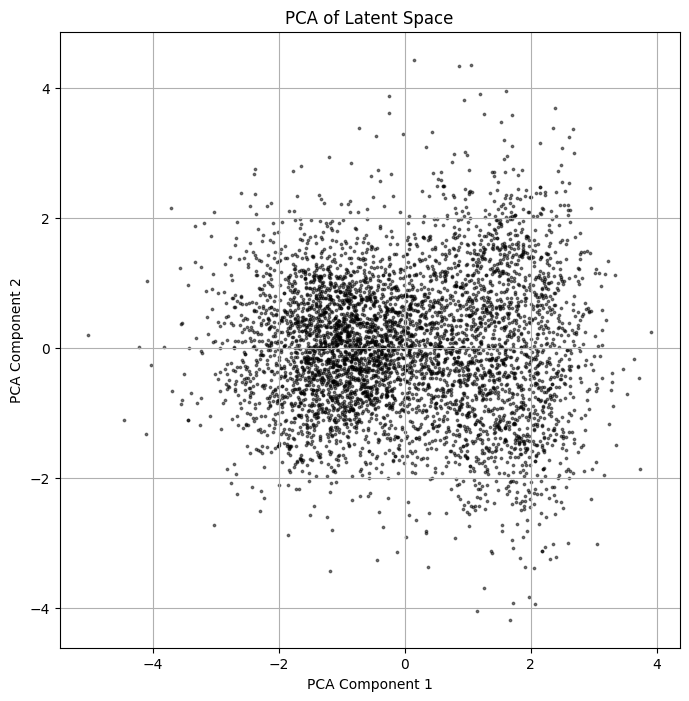

In [ ]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# PCA Visualization of Latent Space Representation

# Reduce to 2D using PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)

# Plotting the PCA results
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_pca[:, 0], z_pca[:, 1], c="black", alpha=0.5, s=3)
plt.title("PCA of Latent Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 28ms/step
Shape of predictions: (10, 32, 32, 3)


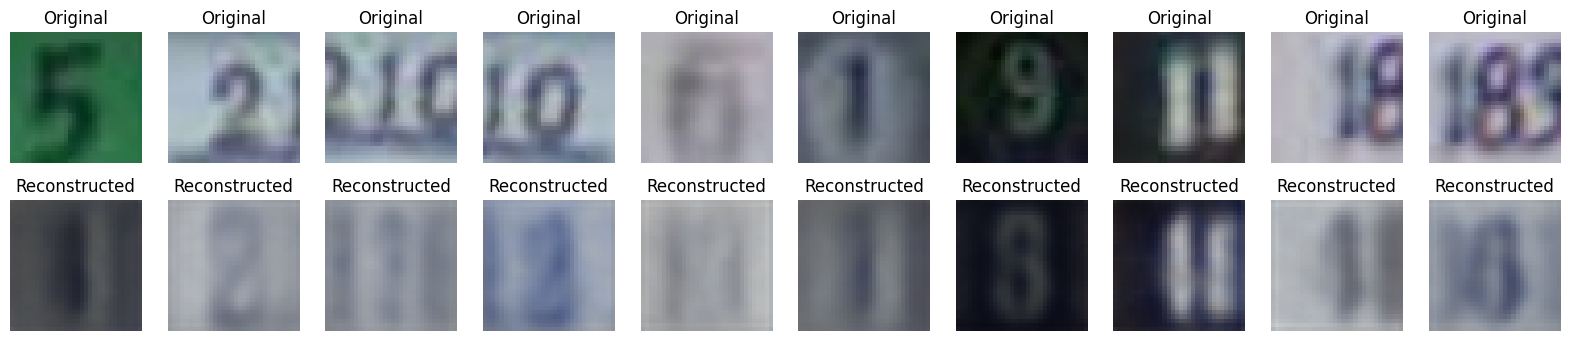

In [ ]:
#Display the original images and out generated images
def display_reconstruction(model, images, num_images=10):
    # Assuming the model returns (z_mean, z_log_var, reconstructions)
    z_mean, z_log_var, pred = model.predict(images[:num_images])

    # Print shape of predictions
    print("Shape of predictions:", pred.shape)  # This should print the shape of the reconstructions

    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
    for i in range(num_images):
        # Display original image
        ax = axes[0, i]
        ax.imshow(images[i].reshape(32, 32, 3))  # Assuming images are reshaped correctly
        ax.title.set_text("Original")
        ax.axis('off')

        # Display reconstructed image
        ax = axes[1, i]
        ax.imshow(pred[i].reshape(32, 32, 3))  # Assuming predictions are reshaped correctly
        ax.title.set_text("Reconstructed")
        ax.axis('off')

    plt.show()

# Usage
# Ensure you have loaded the VAE model and have x_test defined
display_reconstruction(vae, x_test)


814/814 [==============================] - 6s 7ms/step


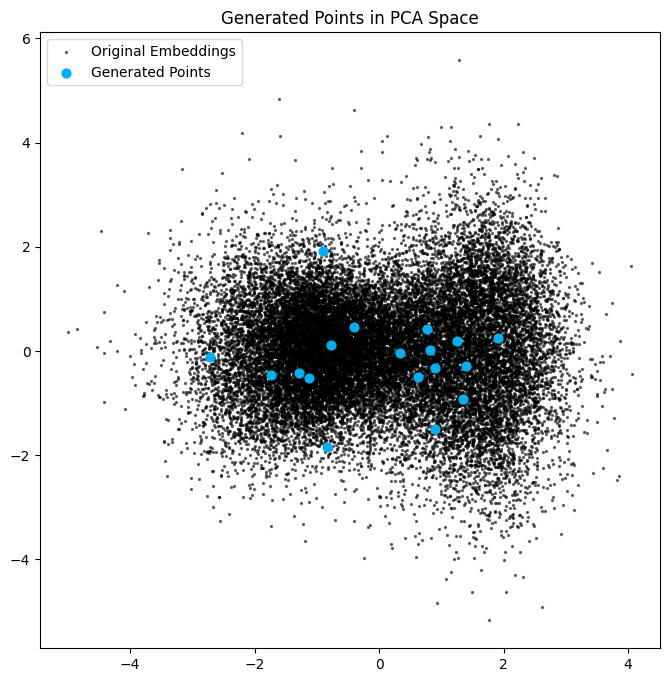

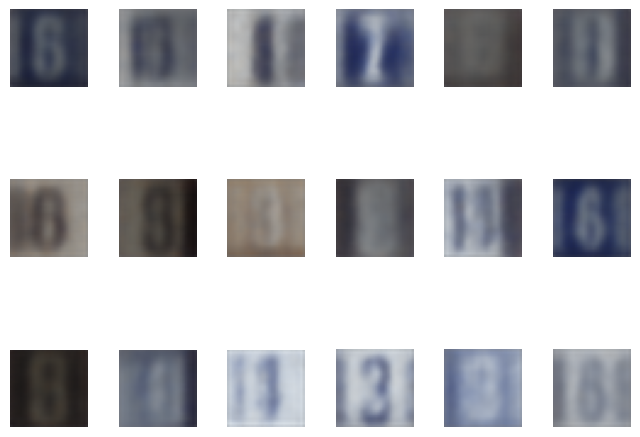

In [ ]:

import matplotlib.pyplot as plt
from scipy.stats import norm


 #Sampling and Visualizing Latent Space with PCA and Image Reconstructions


# Define grid size for generated images
grid_width, grid_height = (6, 3)

# Sample points from a normal distribution in the latent space
z_sample = np.random.normal(size=(grid_width * grid_height, 10))

# Generate reconstructions from sampled points
reconstructions = vae.decoder.predict(z_sample)

z_mean, _, _ = vae.predict(x_test)

# Perform CDF transformations
p = norm.cdf(z_mean)
p_sample = norm.cdf(z_sample)

# Create a figure for the PCA plot
figsize = 8
plt.figure(figsize=(figsize, figsize))

# Scatter plot of the original embeddings
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)  # Reduce original latent space to 2D
plt.scatter(z_pca[:, 0], z_pca[:, 1], c="black", alpha=0.5, s=2, label='Original Embeddings')

# Transform the z_sample using PCA
z_sample_pca = pca.transform(z_sample)
plt.scatter(z_sample_pca[:, 0], z_sample_pca[:, 1], c="#00B0F0", alpha=1, s=40, label='Generated Points')
plt.title("Generated Points in PCA Space")
plt.legend()
plt.show()

# Create a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")


    # Show the image reconstruction
    ax.imshow(reconstructions[i])  # Show image reconstructions

plt.show()